In [1]:
import numpy as np
import random
from random import sample
import scipy as sp
from scipy.stats import qmc
import matplotlib.pyplot as plt

In [2]:
def is_mandelbrot(c,max_recursion):
    '''
    A function that checks if a number is inside the Mandelbrot set.

    Args:
    c - complex number
    max_recursion - maximum checks whether the complex number is
                    is inside the Mandelbrot set.
    '''
    counter=0
    threshold=2
    Z_now=complex(0,0)
    while(counter<max_recursion):
        Z_next=pow(Z_now,2)+c
        if(abs(Z_next)>threshold):
            return counter
        Z_now=Z_next
        # return the iteration when the number escaped
        counter+=1
    return max_recursion

def point_counter(x,y,max_recursion):
    '''
    A function to count the number of points inside the Mandelbrot set,
    which are coming from a sample pool.

    Args:
    x - coordinates of the point
    y - coordinates of the point
    max_recursion - the number of times we want to observe the progression of the number
    '''
    counter=0
    for i,x_i in enumerate(x):
        c=complex(x_i,y[i])
        check=is_mandelbrot(c,max_recursion)
        if check==max_recursion : counter+=1
    return counter

def create_grid(x,y,max_recursion):
    '''
    TO DO: ADD DOCUMENTATION
    '''
    X,Y=np.meshgrid(x,y)
    C=np.vectorize(complex)(X,Y)
    Z=[]
    for row in C:
        Z_row=[]
        for c in row:
            Z_row.append(is_mandelbrot(c,max_recursion))
        Z.append(Z_row)
    Z=np.array(Z)
    return Z


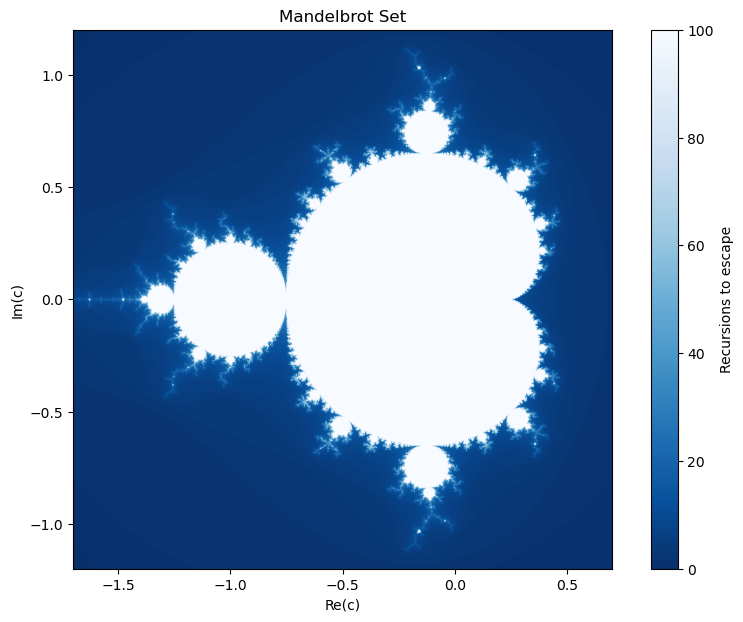

In [95]:
def plot_fractal(Z,x1,x2,y1,y2):
    plt.figure(figsize=(10,7))
    plt.imshow(Z,extent=(x1,x2,y1,y2),cmap='Blues_r',interpolation='bilinear')
    plt.colorbar(label='Recursions to escape')
    plt.title('Mandelbrot Set')
    plt.xlabel('Re(c)')
    plt.ylabel('Im(c)')
    plt.show()

max_iters=100
n=1000
x=np.linspace(-1.7,0.7,n)
y=np.linspace(-1.2,1.2,n)
plot_fractal(create_grid(x,y,max_iters),min(x),max(x),min(y),max(y))

In [15]:
def PR_area_estimate(x_range, y_range, max_iters, num_samples):
    '''
    Estimates area of Mandelbrot set using Pure Random Sampling

    Args:
    x_range - range of the x coordinates
    y_range - range of the y coordinates
    max_recursion -  the number of times we want to observe the progression of the number
    num_samples - number of samples to be taken
    '''
    x_samples = np.random.uniform(x_range[0], x_range[1], num_samples)
    y_samples = np.random.uniform(y_range[0], y_range[1], num_samples)
    mandelbrot_count = point_counter(x_samples, y_samples, max_iters)
    total_area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    estimated_area = total_area * mandelbrot_count / num_samples
    return estimated_area

def LHS_area_estimate(x_range, y_range, max_iters, num_samples):
    '''
    Estimates area of Mandelbrot set using Latin Hypercube sampling method

    Args:
    x_range - range of the x coordinates
    y_range - range of the y coordinates
    max_recursion -  the number of times we want to observe the progression of the number
    num_samples - number of samples to be taken
    '''
    sample_set = qmc.LatinHypercube(d=2)
    sample = sample_set.random(n=num_samples)

    x_samples = x_range[0] + sample[:, 0] * (x_range[1] - x_range[0])
    y_samples = y_range[0] + sample[:, 1] * (y_range[1] - y_range[0])

    mandelbrot_count = point_counter(x_samples, y_samples, max_iters)

    total_area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    estimated_area = total_area * mandelbrot_count / num_samples

    return estimated_area

def ortho_area_estimate(x_range, y_range, max_iters, num_samples, sub_sections): 

    samples_per_section = num_samples // (sub_sections * sub_sections)

    x_size = np.linspace(x_range[0], x_range[1], sub_sections + 1)
    y_size = np.linspace(y_range[0], y_range[1], sub_sections + 1)

    x_samples = []
    y_samples = []

    for i in range(sub_sections):
        for j in range(sub_sections):

            # Latin hypercube for each sub section
            sample_set = qmc.LatinHypercube(d=2)
            cell_samples = sample_set.random(n=samples_per_section)

            #Min and max of y values
            x_cell_min, x_cell_max = x_size[i], x_size[i + 1]
            y_cell_min, y_cell_max = y_size[j], y_size[j + 1]

            # Scales samples to be between 0 and 1 for LHS
            x_cell_samples = x_cell_min + cell_samples[:, 0] * (x_cell_max - x_cell_min)
            y_cell_samples = y_cell_min + cell_samples[:, 1] * (y_cell_max - y_cell_min)

            # Adds scaled points to sample arrays 
            x_samples.extend(x_cell_samples)
            y_samples.extend(y_cell_samples)

    x_samples = np.array(x_samples)
    y_samples = np.array(y_samples)

    mandelbrot_count = point_counter(x_samples, y_samples, max_iters)
    total_area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    estimated_area = total_area * mandelbrot_count / num_samples
    
    return estimated_area


In [ ]:
def run_multiple_simulations(x_range, y_range, max_iters, n, sample_type, num_simulations, sub_sections):
    """
    Runs multiple simulations for the given max iterations, n samples, and type of sampling method.
    Returns the average area estimate from the simulations.
    """
    areas = []
    
    for _ in range(num_simulations):
        if sample_type == "Pure Random":
            est_area = PR_area_estimate(x_range, y_range, max_iters, n)
        elif sample_type == "Latin Hypercube":
            est_area = LHS_area_estimate(x_range, y_range, max_iters, n)
        else:
            est_area = ortho_area_estimate(x_range, y_range, max_iters, n, sub_sections)

        areas.append(est_area)
    
    return np.mean(areas), np.std(areas)


In [83]:
def plot_areas_convergence(x_range, y_range, n_list, max_iters_range, num_simulations, sub_sections):
    """
    Plots the convergence of the area estimates with respect to increasing sample sizes and iterations.
    Runs multiple simulations for each combination of iterations and samples for three sampling types.
    """
    sampling_types = ["Pure Random", "Latin Hypercube", "Orthogonal"]
    area_results = {sample_type: {} for sample_type in sampling_types}
    print("Means and Errors of A(i,s):")

    # Run simulations for all sampling methods
    for sample_type in sampling_types:
        for max_iters in max_iters_range:
            areas = []
            area_diffs = []
            errors = []

            print(f"\nMax Iterations i = {max_iters}, Sampling Method = {sample_type}")

            for n in n_list:
                avg_area, st_dev = run_multiple_simulations(x_range, y_range, max_iters, n, sample_type, num_simulations, sub_sections)
                areas.append(avg_area)
                RMSE = st_dev / np.sqrt(num_simulations)
                errors.append(RMSE)

                print(f"  Sample Size (s = {n}): Mean A(i,s) = {avg_area:.4f}, RMSE = {RMSE:.4f}")

            final_area = areas[-1] # Last area/iteration combination, assumed to be optimal
            for area in areas[:-1]:
                diff = abs(area - final_area)
                area_diffs.append(diff)

            area_results[sample_type][max_iters] = (area_diffs, errors[:-1], areas)

    fig, axs = plt.subplots(3, 3, figsize=(18, 18))
    colors = plt.cm.viridis(np.linspace(0, 1, len(max_iters_range)))

    # Plot 1: Convergence (A(j,s) - A(i,s))
    for i, sample_type in enumerate(sampling_types):
        for j, (max_iters, (diffs, errs, _)) in enumerate(area_results[sample_type].items()):
            axs[0, i].errorbar(n_list[:-1], diffs, yerr=errs, label=f"Max Iter = {max_iters}", color=colors[j], capsize=3, marker='o', linestyle='-', linewidth=2)
        axs[0, i].set_title(f'Convergence of A(j,s) - A(i,s) ({sample_type})')
        axs[0, i].set_xlabel("Sample Size (s)")
        axs[0, i].set_ylabel("Difference A(j,s) - A(i,s)")
        axs[0, i].grid(True, which='both', linestyle='--', alpha=0.7)
        axs[0, i].legend(fontsize=10)

    # Plot 2: Stabilization of Area Estimates (A(i,s))
    for i, sample_type in enumerate(sampling_types):
        for j, (max_iters, (_, _, areas)) in enumerate(area_results[sample_type].items()):
            axs[1, i].plot(n_list, areas, label=f"Max Iter = {max_iters}", color=colors[j], marker='x', linestyle='-', linewidth=2)
        axs[1, i].set_title(f'Stabilization of Area Estimates A(i,s) ({sample_type})')
        axs[1, i].set_xlabel("Sample Size (s)")
        axs[1, i].set_ylabel("Area Estimate A(i,s)")
        axs[1, i].grid(True, which='both', linestyle='--', alpha=0.7)
        axs[1, i].legend(fontsize=10)

    # Plot 3: Stabilization of RMSE
    for i, sample_type in enumerate(sampling_types):
        for j, (max_iters, (_, errs, _)) in enumerate(area_results[sample_type].items()):
            axs[2, i].plot(n_list[:-1], errs, label=f"Max Iter = {max_iters}", color=colors[j], marker='s', linestyle='-', linewidth=2)
        axs[2, i].set_title(f'Stabilization of RMSE ({sample_type})')
        axs[2, i].set_xlabel("Sample Size (s)")
        axs[2, i].set_ylabel("RMSE")
        axs[2, i].grid(True, which='both', linestyle='--', alpha=0.7)
        axs[2, i].legend(fontsize=10)

    plt.tight_layout()
    plt.show()


Means and Errors of A(i,s):

Max Iterations i = 10, Sampling Method = Pure Random
  Sample Size (s = 100): Mean A(i,s) = 2.0462, RMSE = 0.0662
  Sample Size (s = 500): Mean A(i,s) = 2.0281, RMSE = 0.0308
  Sample Size (s = 1000): Mean A(i,s) = 2.0045, RMSE = 0.0280
  Sample Size (s = 5000): Mean A(i,s) = 2.0197, RMSE = 0.0174
  Sample Size (s = 7000): Mean A(i,s) = 2.0283, RMSE = 0.0128
  Sample Size (s = 10000): Mean A(i,s) = 2.0155, RMSE = 0.0090

Max Iterations i = 50, Sampling Method = Pure Random
  Sample Size (s = 100): Mean A(i,s) = 1.5730, RMSE = 0.0909
  Sample Size (s = 500): Mean A(i,s) = 1.5827, RMSE = 0.0293
  Sample Size (s = 1000): Mean A(i,s) = 1.5604, RMSE = 0.0137
  Sample Size (s = 5000): Mean A(i,s) = 1.5681, RMSE = 0.0135
  Sample Size (s = 7000): Mean A(i,s) = 1.5686, RMSE = 0.0147
  Sample Size (s = 10000): Mean A(i,s) = 1.5825, RMSE = 0.0114

Max Iterations i = 100, Sampling Method = Pure Random
  Sample Size (s = 100): Mean A(i,s) = 1.6008, RMSE = 0.1023
  Samp

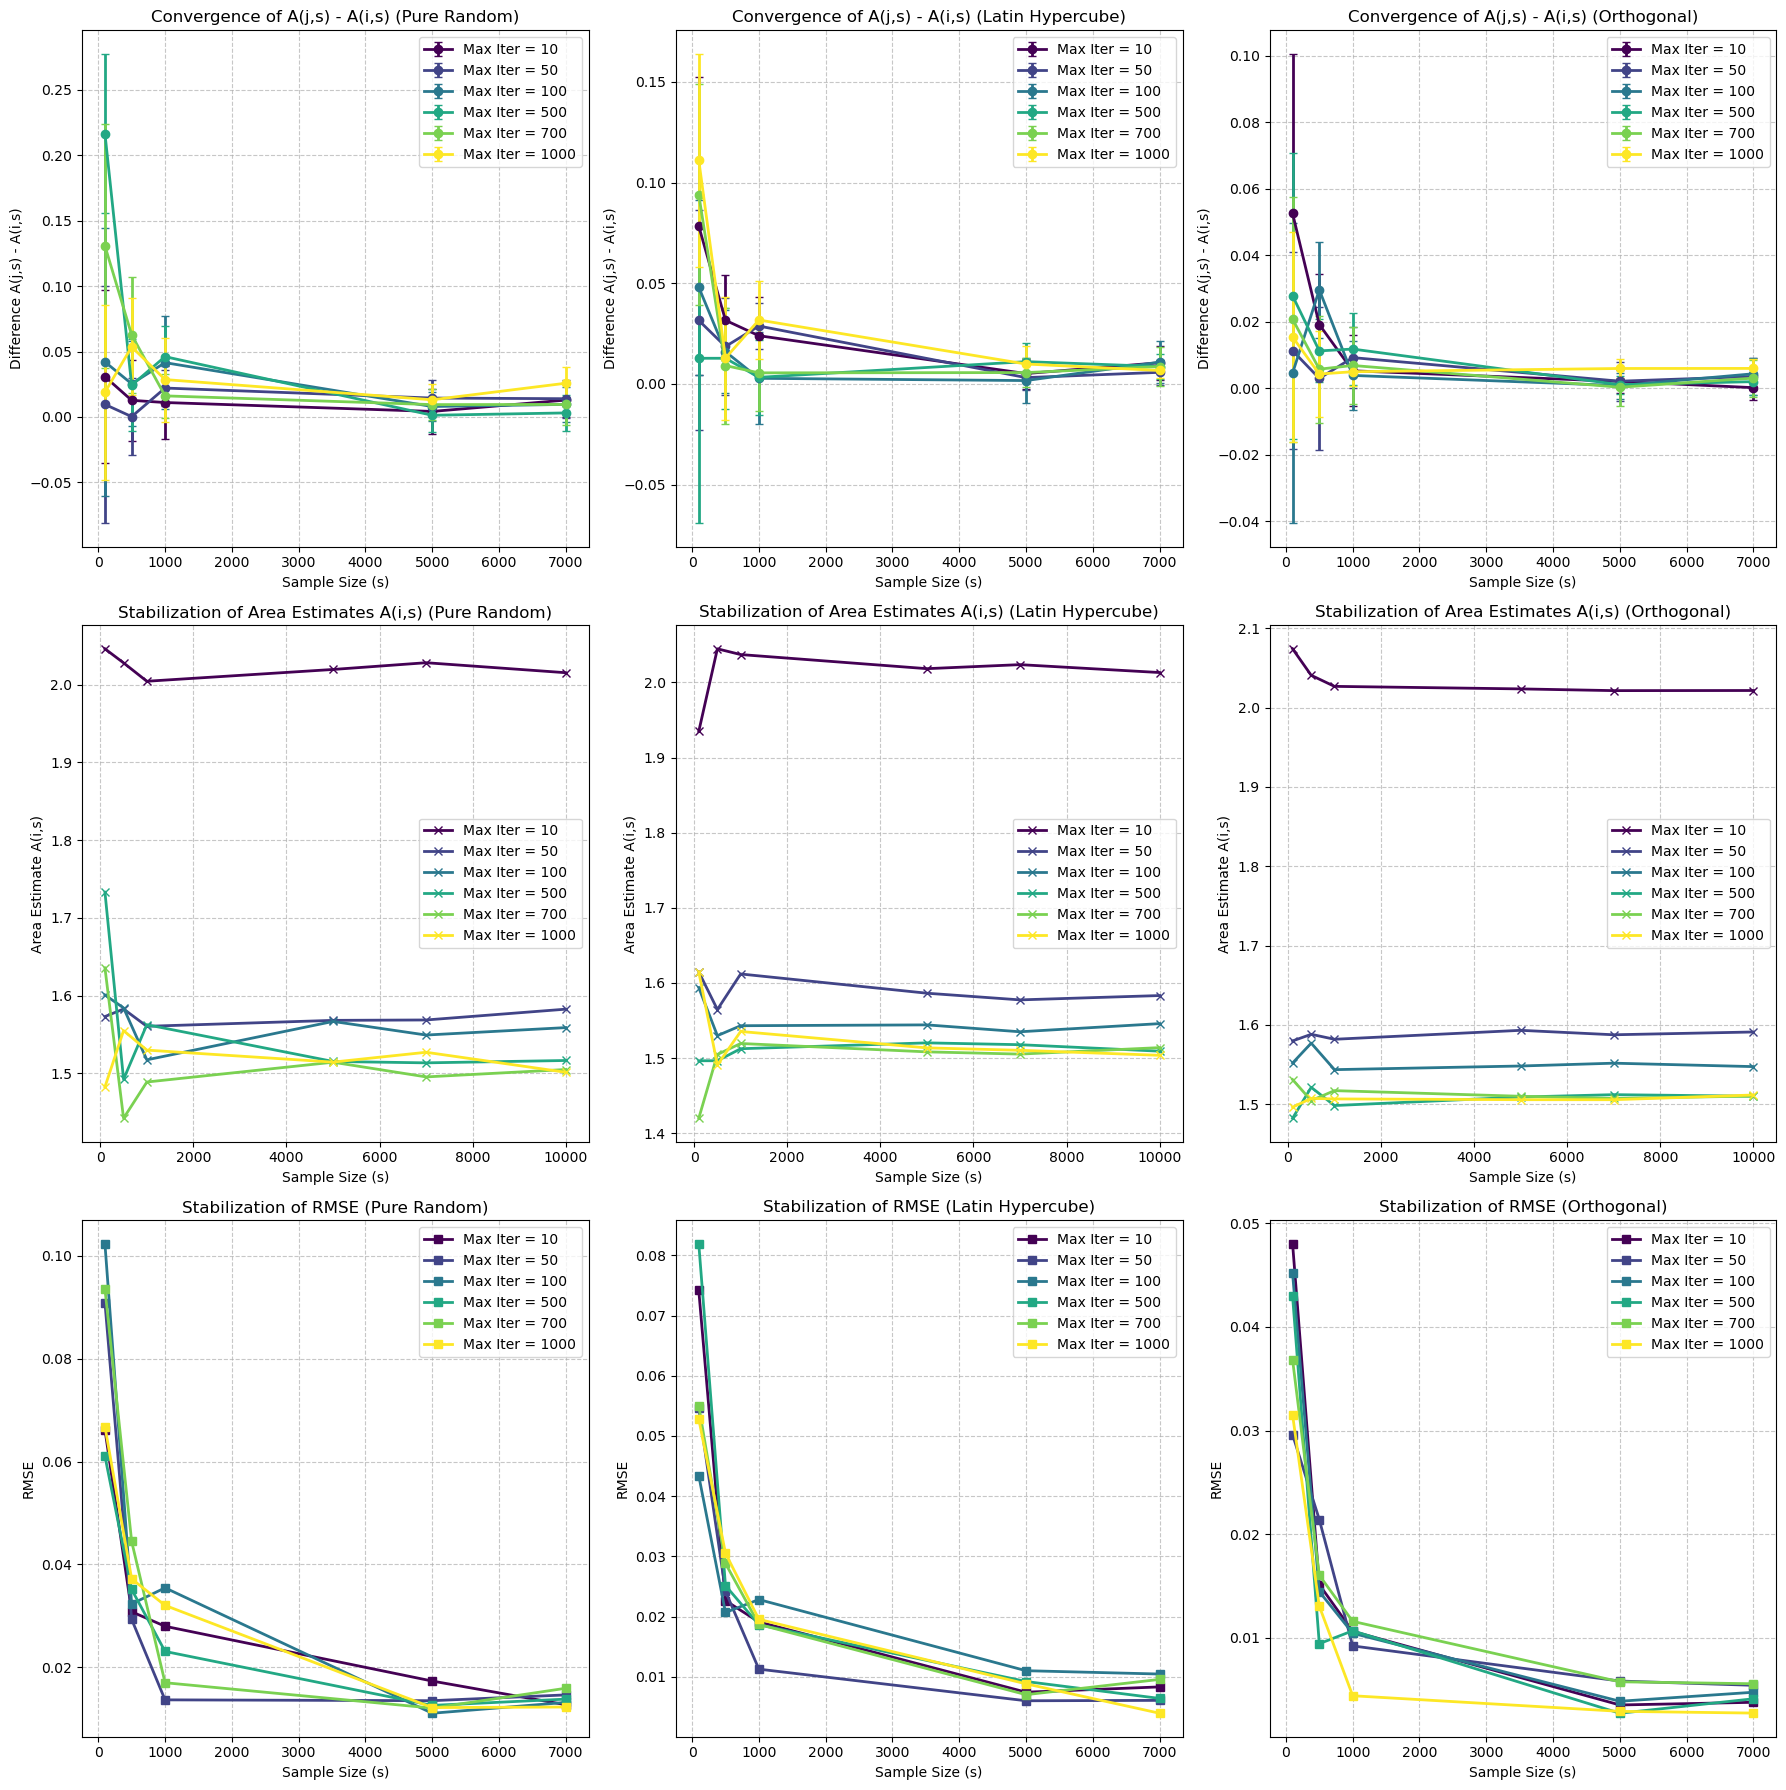

In [84]:
x_range = (-1.7,0.7)
y_range = (-1.7,1.2)
max_iters_range = [10, 50, 100, 500, 700, 1000]
n_list = [100, 500, 1000, 5000, 7000, 10000]
num_simulations = 10
sub_sections = 5

plot_areas_convergence(x_range, y_range, n_list, max_iters_range, num_simulations, sub_sections)